In [1]:
import numpy as np 
import pandas as pd

import re
import string
import os

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_train = pd.read_csv("./labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
df_train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [3]:
df_test=pd.read_csv("./testData.tsv", header=0, delimiter="\t", quoting=3)
df_test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [4]:
def data_cleaning(raw_data):
    raw_data = raw_data.translate(str.maketrans('', '', string.punctuation + string.digits))
    words = raw_data.lower().split()
    stops = set(stopwords.words("english"))
    useful_words = [w for w in words if not w in stops]
    return( " ".join(useful_words))

df_train['review']=df_train['review'].apply(data_cleaning)
df_test["review"]=df_test["review"].apply(data_cleaning)

In [5]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

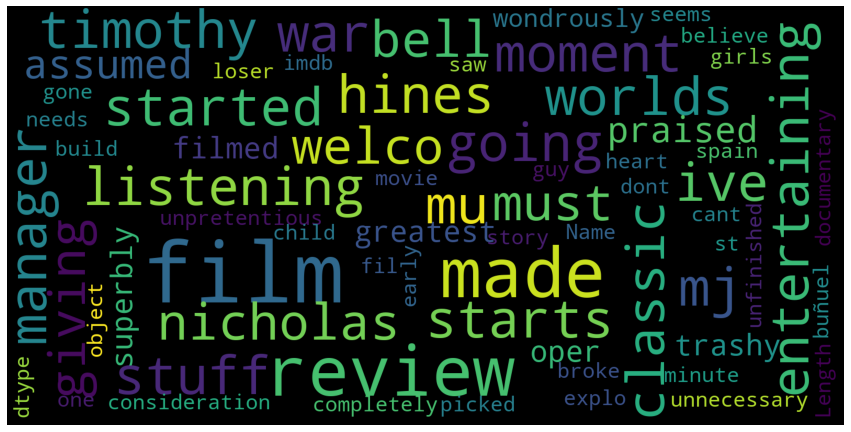

In [6]:
def generate_wordcloud(data, title = None):
    wordcloud = WordCloud(
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=4).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

generate_wordcloud(df_train["review"])

In [7]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

id           0
sentiment    0
review       0
dtype: int64
id        0
review    0
dtype: int64


In [8]:
import tensorflow as tf
# from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [9]:
y = df_train["sentiment"].values
train_reviews = df_train["review"]
test_reviews = df_test["review"]

In [10]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_reviews))
list_tokenized_train = tokenizer.texts_to_sequences(train_reviews)
list_tokenized_test = tokenizer.texts_to_sequences(test_reviews)

In [11]:
max_length = 370
X_train = pad_sequences(list_tokenized_train, maxlen=max_length)
X_test = pad_sequences(list_tokenized_test, maxlen=max_length)

In [ ]:
def tokenize(sentence):
  max_features = 6000
  tokenizer = Tokenizer(num_words=max_features)
  tokenizer.fit_on_texts(list(train_reviews))
  list_tokenized_test = tokenizer.texts_to_sequences(sentence)
  max_length = 360
  idv_test = pad_sequences(list_tokenized_test, maxlen=max_length)

  return idv_test

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if logs.get('accuracy') > 0.95:
            print('\n Stopped Training!\n')
            self.model.stop_training = True

def train_model(model, model_name, n_epochs, batch_size, X_data, y_data, validation_split):    
    checkpoint_path = model_name+"_cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    callbacks_earlystop = myCallback()
    history = model.fit(
        X_data,
        y_data,
        steps_per_epoch=batch_size,
        epochs=n_epochs,
        validation_split=validation_split,
        verbose=1,
        callbacks=[cp_callback, callbacks_earlystop]
    )
    return history

In [13]:
def generate_graph(history):
    plt.plot(history.history['accuracy'], 'b')
    plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

## MODEL A

In [14]:
class Model_A():
    def __new__(self):
        inp = Input(shape=(max_length, ))
        embed_size = 128
        x = Embedding(max_features, embed_size)(inp)
        x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
        x = GlobalMaxPool1D()(x)
        x = Dropout(0.1)(x)
        x = Dense(50, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
        
        return model

model_a = Model_A()

In [15]:
print(model_a.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 370)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 370, 128)          768000    
_________________________________________________________________
lstm_layer (LSTM)            (None, 370, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [16]:
model_a = Model_A()
history_a = train_model(model_a, "model_a", 10, 64, X_train, y, 0.2)

Epoch 1/10
64/64 [==============================] - 10s 97ms/step - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5016

Epoch 00001: saving model to model_a_cp-0001.ckpt
Epoch 2/10
64/64 [==============================] - 5s 85ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6931 - val_accuracy: 0.5164

Epoch 00002: saving model to model_a_cp-0002.ckpt
Epoch 3/10
64/64 [==============================] - 5s 85ms/step - loss: 0.6930 - accuracy: 0.5106 - val_loss: 0.6931 - val_accuracy: 0.5046

Epoch 00003: saving model to model_a_cp-0003.ckpt
Epoch 4/10
64/64 [==============================] - 5s 84ms/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6931 - val_accuracy: 0.5072

Epoch 00004: saving model to model_a_cp-0004.ckpt
Epoch 5/10
64/64 [==============================] - 5s 85ms/step - loss: 0.6930 - accuracy: 0.5140 - val_loss: 0.6931 - val_accuracy: 0.5084

Epoch 00005: saving model to model_a_cp-0005.ckpt
Epoch 6/10
64/64 [=====================

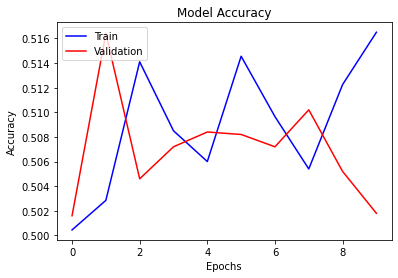

In [17]:
generate_graph(history_a)

## MODEL B

In [20]:
class Model_B():
    def __new__(self):
        inp = Input(shape=(max_length, ))
        x = Embedding(max_features, 128)(inp)
        x = SpatialDropout1D(0.25)(x)
        x = LSTM(100, dropout=0.5)(x)
        x = Dropout(0.5)(x)
        x = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
        return model
    
model_b = Model_B()

In [21]:
print(model_b.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 370)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 370, 128)          768000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 370, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 859,701
Trainable params: 859,701
Non-trainable params: 0
_____________________________________________________

In [22]:
model_b = Model_B()
history_b = train_model(model_b, "model_b", 10, 64, X_train, y, 0.2)

Epoch 1/10
64/64 [==============================] - 8s 98ms/step - loss: 0.6456 - accuracy: 0.6041 - val_loss: 0.3399 - val_accuracy: 0.8622

Epoch 00001: saving model to model_b_cp-0001.ckpt
Epoch 2/10
64/64 [==============================] - 6s 91ms/step - loss: 0.2914 - accuracy: 0.8817 - val_loss: 0.2984 - val_accuracy: 0.8770

Epoch 00002: saving model to model_b_cp-0002.ckpt
Epoch 3/10
64/64 [==============================] - 6s 91ms/step - loss: 0.2198 - accuracy: 0.9198 - val_loss: 0.3262 - val_accuracy: 0.8770

Epoch 00003: saving model to model_b_cp-0003.ckpt
Epoch 4/10
64/64 [==============================] - 6s 91ms/step - loss: 0.1874 - accuracy: 0.9321 - val_loss: 0.3249 - val_accuracy: 0.8732

Epoch 00004: saving model to model_b_cp-0004.ckpt
Epoch 5/10
64/64 [==============================] - 6s 92ms/step - loss: 0.1639 - accuracy: 0.9391 - val_loss: 0.3304 - val_accuracy: 0.8714

Epoch 00005: saving model to model_b_cp-0005.ckpt
Epoch 6/10
64/64 [======================

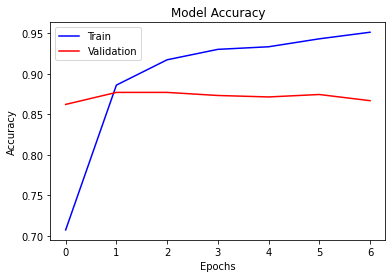

In [23]:
generate_graph(history_b)

## MODEL C

In [25]:
class Model_C():
  def __new__(self):
    embed_size = 128
    model = Sequential()
    model.add(Embedding(max_features, embed_size))
    model.add(Bidirectional(LSTM(75, return_sequences = True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.03))
    model.add(Dense(8, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
    
model_c = Model_C()

In [26]:
print(model_c.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         768000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 150)         122400    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 150)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                2416      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_10 (Dropout)         (None, 8)                

In [28]:
model_c = Model_C()
history_c = train_model(model_c, "model_c", 10, 128, X_train, y, 0.2)

Epoch 1/10
128/128 [==============================] - 14s 89ms/step - loss: 0.5998 - accuracy: 0.6511 - val_loss: 0.3160 - val_accuracy: 0.8684

Epoch 00001: saving model to model_c_cp-0001.ckpt
Epoch 2/10
128/128 [==============================] - 11s 84ms/step - loss: 0.2600 - accuracy: 0.9005 - val_loss: 0.2985 - val_accuracy: 0.8748

Epoch 00002: saving model to model_c_cp-0002.ckpt
Epoch 3/10
128/128 [==============================] - 11s 84ms/step - loss: 0.1901 - accuracy: 0.9344 - val_loss: 0.3284 - val_accuracy: 0.8726

Epoch 00003: saving model to model_c_cp-0003.ckpt
Epoch 4/10
128/128 [==============================] - 11s 84ms/step - loss: 0.1351 - accuracy: 0.9572 - val_loss: 0.3700 - val_accuracy: 0.8710

Epoch 00004: saving model to model_c_cp-0004.ckpt

 Stopped Training!



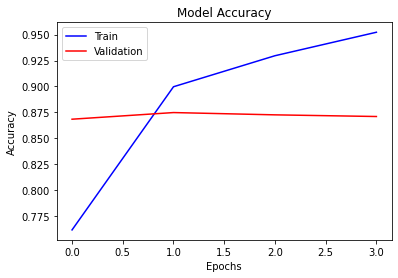

In [29]:
generate_graph(history_c)

In [30]:
model_c_1 = Model_C()
history_c_1 = train_model(model_c_1, "model_c_1", 10, 16, X_train, y, 0.4)

Epoch 1/10
16/16 [==============================] - 11s 534ms/step - loss: 0.6899 - accuracy: 0.5692 - val_loss: 0.6587 - val_accuracy: 0.7769

Epoch 00001: saving model to model_c_1_cp-0001.ckpt
Epoch 2/10
16/16 [==============================] - 8s 497ms/step - loss: 0.5974 - accuracy: 0.7972 - val_loss: 0.5173 - val_accuracy: 0.7578

Epoch 00002: saving model to model_c_1_cp-0002.ckpt
Epoch 3/10
16/16 [==============================] - 8s 492ms/step - loss: 0.4693 - accuracy: 0.7882 - val_loss: 0.4463 - val_accuracy: 0.8079

Epoch 00003: saving model to model_c_1_cp-0003.ckpt
Epoch 4/10
16/16 [==============================] - 8s 505ms/step - loss: 0.3746 - accuracy: 0.8524 - val_loss: 0.3718 - val_accuracy: 0.8507

Epoch 00004: saving model to model_c_1_cp-0004.ckpt
Epoch 5/10
16/16 [==============================] - 8s 495ms/step - loss: 0.3040 - accuracy: 0.8854 - val_loss: 0.3371 - val_accuracy: 0.8629

Epoch 00005: saving model to model_c_1_cp-0005.ckpt
Epoch 6/10
16/16 [======

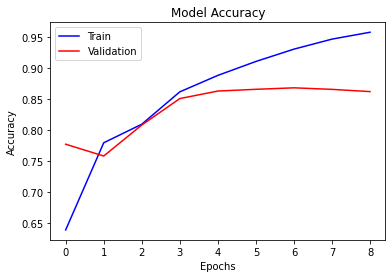

In [31]:
generate_graph(history_c_1)

## MODEL D

In [37]:
class Model_D():
  def __new__(self):
    embed_size = 64
    model = Sequential()
    model.add(Embedding(max_features, embed_size))
    model.add(LSTM(50, return_sequences = True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.8))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model_d = Model_D()

In [38]:
print(model_d.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 64)          384000    
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 50)          23000     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 50)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 16)                816       
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 407,833
Trainable params: 407,833
Non-trainable params: 0
________________________________________________

In [41]:
model_d = Model_D()
history_d = train_model(model_d, "model_d", 20, 16, X_train, y, 0.2)

Epoch 1/20
16/16 [==============================] - 5s 211ms/step - loss: 0.6927 - accuracy: 0.5084 - val_loss: 0.6893 - val_accuracy: 0.7212

Epoch 00001: saving model to model_d_cp-0001.ckpt
Epoch 2/20
16/16 [==============================] - 3s 184ms/step - loss: 0.6858 - accuracy: 0.5635 - val_loss: 0.6606 - val_accuracy: 0.7678

Epoch 00002: saving model to model_d_cp-0002.ckpt
Epoch 3/20
16/16 [==============================] - 3s 182ms/step - loss: 0.6436 - accuracy: 0.6664 - val_loss: 0.5703 - val_accuracy: 0.7974

Epoch 00003: saving model to model_d_cp-0003.ckpt
Epoch 4/20
16/16 [==============================] - 3s 182ms/step - loss: 0.5670 - accuracy: 0.7281 - val_loss: 0.4886 - val_accuracy: 0.8222

Epoch 00004: saving model to model_d_cp-0004.ckpt
Epoch 5/20
16/16 [==============================] - 3s 182ms/step - loss: 0.5100 - accuracy: 0.7533 - val_loss: 0.4056 - val_accuracy: 0.8434

Epoch 00005: saving model to model_d_cp-0005.ckpt
Epoch 6/20
16/16 [=================

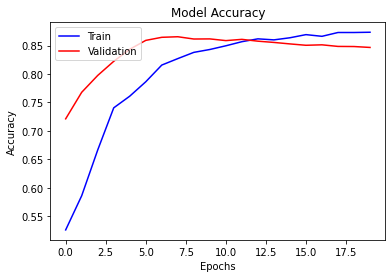

In [42]:
generate_graph(history_d)

In [54]:
def predict_func(model):
  prediction = model.predict(X_test)
  y_pred = (prediction > 0.5)

  df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
  y_test = df_test["sentiment"]

  cf_matrix = confusion_matrix(y_pred, y_test)
  f1_score_calc = cf_matrix[0][0] / (cf_matrix[0][0] + 0.5 * (cf_matrix[0][1] + cf_matrix[1][0]))
  print('F1-score: %.3f' % f1_score_calc)
  print("Confusion Matrix : ", cf_matrix)

  return f1_score_calc


In [55]:
model_a_score = predict_func(model_a)

F1-score: 0.663
Confusion Matrix :  [[12106 11916]
 [  394   584]]


In [56]:
model_b_score = predict_func(model_b)

F1-score: 0.861
Confusion Matrix :  [[10974  2012]
 [ 1526 10488]]


In [57]:
model_c_score = predict_func(model_c)

F1-score: 0.863
Confusion Matrix :  [[10993  1993]
 [ 1507 10507]]


In [58]:
model_c_1_score = predict_func(model_c_1)

F1-score: 0.853
Confusion Matrix :  [[10922  2195]
 [ 1578 10305]]


In [59]:
model_d_score = predict_func(model_d)

F1-score: 0.837
Confusion Matrix :  [[10683  2335]
 [ 1817 10165]]


In [60]:
from sklearn.ensemble import RandomForestClassifier

model_random_forest = RandomForestClassifier(n_estimators = 150, random_state=45, bootstrap = "False", criterion="gini", min_samples_split = 10, min_samples_leaf = 1)
model_random_forest.fit(X_train, y)

RandomForestClassifier(bootstrap='False', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=45, verbose=0,
                       warm_start=False)

In [61]:
random_forest_score = predict_func(model_random_forest)

F1-score: 0.547
Confusion Matrix :  [[6995 6074]
 [5505 6426]]


In [70]:
results_fine_tuned = {"Model_A " : model_a_score,
          "Model_B" : model_b_score,
          "Model_C" : model_c_score,
          "Model_D": model_d_score,
          "Random Forest": random_forest_score}

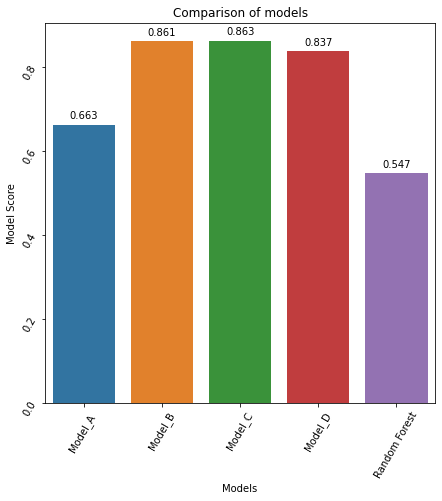

In [71]:
plt.figure(figsize=(7, 7))
plt.title('Comparison of models')
plt.xlabel('Models')
plt.ylabel('Model Score')
plt.xticks(rotation=60)
plt.yticks(rotation=60)
plots = sns.barplot([i for i in results_fine_tuned], [results_fine_tuned[i] for i in results_fine_tuned])
for p in plots.patches:
    plots.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

## REFERENCES

1. https://www.kaggle.com/yclaudel/recommendation-engine-with-networkx
2. https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
3. https://medium.datadriveninvestor.com/deep-learning-lstm-for-sentiment-analysis-in-tensorflow-with-keras-api-92e62cde7626
4. https://www.tensorflow.org/tutorials/keras/save_and_load
5. https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
6. https://www.kaggle.com/noi031/sentiment-analysis-with-self-attention
7. https://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/
8. https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras
9. https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
10. DataSet - https://www.kaggle.com/c/word2vec-nlp-tutorial/data?select=labeledTrainData.tsv.zip